# Project Title
### Data Engineering Capstone Project

#### Project Summary

With the globalization of the economy, international travel such as international travel, transnational business trips, and study abroad has become a very common phenomenon. 
Knowing the behavior of international travelers in the past, the climate and population of the destination and other data can provide international travelers with reference for smooth travel.

Based on the Immigration data provided by the US National Tourism and Trade Office and U.S. City Demographic Data and Global City Temperature data, a Data Lake with Data Model and ETL and Data Pipeline created with Pyspark to provide usable data sources for analyzing the behavior of international travelers, the climate and demography of American cities.

The project follows the follow steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

In [1]:
# Do all imports and installs here
import pandas as pd
pd.set_option('max_columns', 300)
import matplotlib.pyplot as plt
%matplotlib inline

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf, date_format, year, month
from pyspark.sql.types import *

spark = SparkSession.builder.\
config("spark.jars.packages","saurfang:spark-sas7bdat:2.0.0-s_2.11")\
.enableHiveSupport().getOrCreate()

### Step 1: Scope the Project and Gather Data

#### Scope 

Create a Data Lake with Star Schema data model for immigration analytics which includes ETL and Data Pipeline by using Pyspark. The final data for tables (fact and dimension tables) is stored as parquet files.

#### Describe and Gather Data 
- I94 Immigration Data: This data comes from the US National Tourism and Trade Office which contains international visitor arrival statistics by world regions and select countries (including top 20), type of visa, mode of transportation, age groups, states visited (first intended address only), and the top ports of entry (for select countries)
- World Temperature Data: This dataset came from Kaggle which contains Global Land Temperatures By City
- U.S. City Demographic Data: This data comes from OpenSoft which contains information about the demographics of all US cities and census-designated places.

In [2]:
# Load the I94 Immigration Data
# immigration_spark = spark.read.format('com.github.saurfang.sas.spark').load('../../data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat')
immigration_spark = spark.read.parquet("sas_data")
# Load the World Temperature data
temp_spark = spark.read.csv('../../data2/GlobalLandTemperaturesByCity.csv', header = True)
# Load the us city demographics data
demographics_spark = spark.read.csv('us-cities-demographics.csv', header = True, sep = ';')

In [3]:
# Load the code mapper data for country/state/port

i94cit_res = spark.read.csv('./code_mapper/i94cit_res.csv', header = True)
i94port = spark.read.csv('./code_mapper/i94port.csv', header = True)
i94mode = spark.read.csv('./code_mapper/i94mode.csv', header = True)
i94addr = spark.read.csv('./code_mapper/i94addr.csv', header = True)

### Step 2: Explore and Assess the Data
#### Explore the Data 
Identify data quality issues, like missing values, duplicate data, etc.

#### Immigration Data

In [4]:
immigration_spark.limit(5).toPandas()

,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,i94bir,i94visa,count,dtadfile,visapost,occup,entdepa,entdepd,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,5748517.0,2016.0,4.0,245.0,438.0,LOS,20574.0,1.0,CA,20582.0,40.0,1.0,1.0,20160430,SYD,None,G,O,None,M,1976.0,10292016,F,None,QF,9.495387e+10,00011,B1
1,5748518.0,2016.0,4.0,245.0,438.0,LOS,20574.0,1.0,NV,20591.0,32.0,1.0,1.0,20160430,SYD,None,G,O,None,M,1984.0,10292016,F,None,VA,9.495562e+10,00007,B1
2,5748519.0,2016.0,4.0,245.0,438.0,LOS,20574.0,1.0,WA,20582.0,29.0,1.0,1.0,20160430,SYD,None,G,O,None,M,1987.0,10292016,M,None,DL,9.495641e+10,00040,B1
3,5748520.0,2016.0,4.0,245.0,438.0,LOS,20574.0,1.0,WA,20588.0,29.0,1.0,1.0,20160430,SYD,None,G,O,None,M,1987.0,10292016,F,None,DL,9.495645e+10,00040,B1
4,5748521.0,2016.0,4.0,245.0,438.0,LOS,20574.0,1.0,WA,20588.0,28.0,1.0,1.0,20160430,SYD,None,G,O,None,M,1988.0,10292016,M,None,DL,9.495639e+10,00040,B1


In [5]:
# check the Null for all columns in Immigration Data
def visualize_null(df, title=None):
    """
    
    """
    Null_Dict = {col:df.filter(df[col].isNull()).count() for col in df.columns}
    keys = []
    values = []
    print('====Null count for fields ====\n')
    plt.figure(figsize=(20,10))
    for k, v in Null_Dict.items():
        if v != 0:
            keys.append(k)
            values.append(v)
            print(k,':', v)
    print('\n=============================\n')        
    plt.bar(keys, values)
    if title != None:
        plt.title(title)


====Null count for fields ====

i94mode : 239
i94addr : 152592
depdate : 142457
i94bir : 802
dtadfile : 1
visapost : 1881250
occup : 3088187
entdepa : 238
entdepd : 138429
entdepu : 3095921
matflag : 138429
biryear : 802
dtaddto : 477
gender : 414269
insnum : 2982605
airline : 83627
fltno : 19549




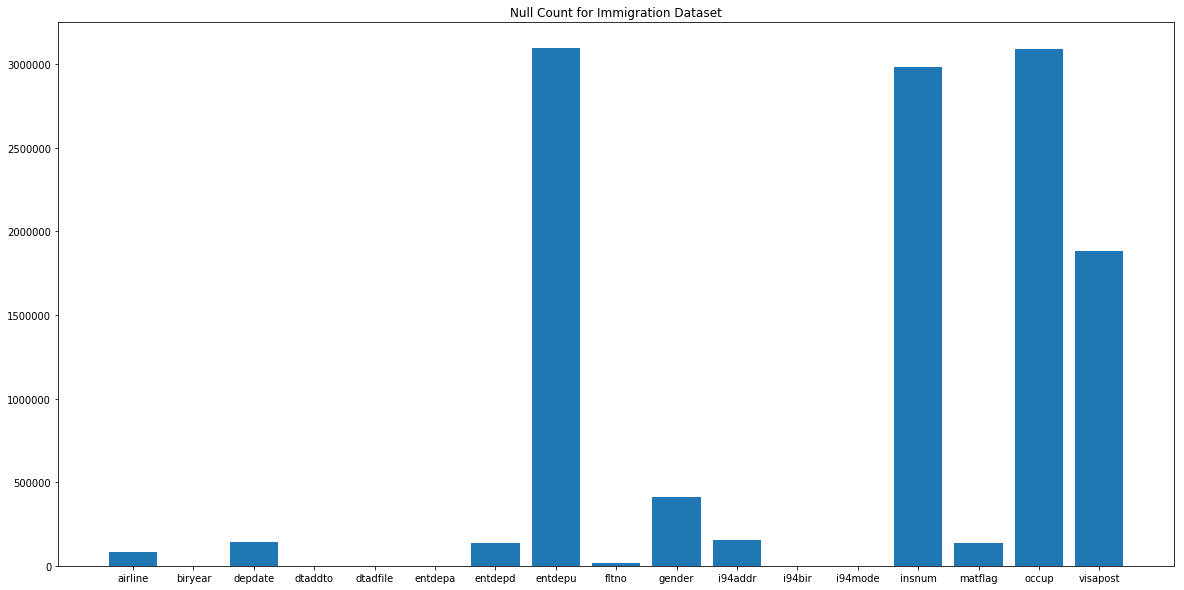

In [6]:
visualize_null(immigration_spark, title = 'Null Count for Immigration Dataset')

In [7]:
# check the duplicates for all columns in Immigration Data
(immigration_spark.count(), immigration_spark.dropDuplicates().count())

(3096313, 3096313)

immigration_spark = immigration_spark.select('cicid', 
                         'i94cit', 
                         'i94res', 
                         'i94port', 
                         'arrdate', 'i94mode', 'i94addr', 'depdate', 
                         'i94bir', 
                         'i94visa', 'gender', 'airline', 'admnum', 'fltno', 'visatype')
immigration_spark.toPandas().head(5)

##### World Temperature Data

In [8]:
temp_spark.limit(5).toPandas()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.7369999999999999,Århus,Denmark,57.05N,10.33E
1,1743-12-01,None,None,Århus,Denmark,57.05N,10.33E
2,1744-01-01,None,None,Århus,Denmark,57.05N,10.33E
3,1744-02-01,None,None,Århus,Denmark,57.05N,10.33E
4,1744-03-01,None,None,Århus,Denmark,57.05N,10.33E


In [9]:
temp_spark.count()

8599212

====Null count for fields ====

AverageTemperature : 364130
AverageTemperatureUncertainty : 364130




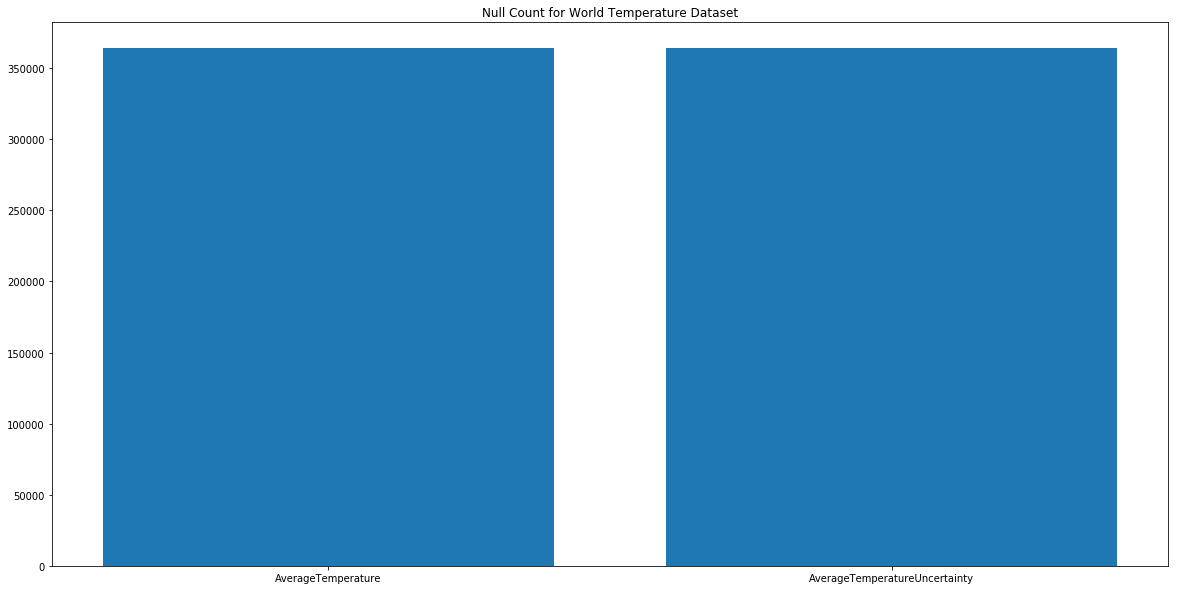

In [10]:
visualize_null(temp_spark, title = 'Null Count for World Temperature Dataset')

In [11]:
# check the duplicates for all columns in World Temperature
(temp_spark.count(), temp_spark.dropDuplicates().count())

(8599212, 8599212)

In [12]:
temp_spark.filter("Country == 'United States'").count()

687289

In [13]:
# check the latest date for the Temperature data
from pyspark.sql.functions import min, max
temp_spark.select(max('dt')).show()

+----------+
|   max(dt)|
+----------+
|2013-09-01|
+----------+



##### U.S. City Demographic Data

In [14]:
demographics_spark.limit(5).toPandas()

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
0,Silver Spring,Maryland,33.8,40601,41862,82463,1562,30908,2.6,MD,Hispanic or Latino,25924
1,Quincy,Massachusetts,41.0,44129,49500,93629,4147,32935,2.39,MA,White,58723
2,Hoover,Alabama,38.5,38040,46799,84839,4819,8229,2.58,AL,Asian,4759
3,Rancho Cucamonga,California,34.5,88127,87105,175232,5821,33878,3.18,CA,Black or African-American,24437
4,Newark,New Jersey,34.6,138040,143873,281913,5829,86253,2.73,NJ,White,76402


====Null count for fields ====

Male Population : 3
Female Population : 3
Number of Veterans : 13
Foreign-born : 13
Average Household Size : 16




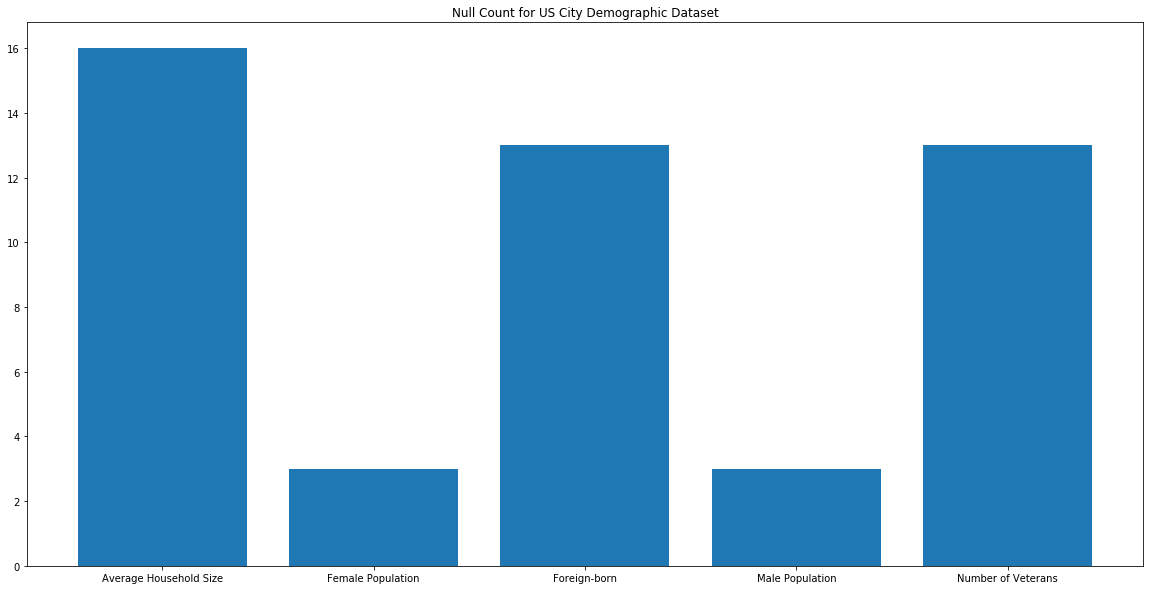

In [15]:
visualize_null(demographics_spark, title = 'Null Count for US City Demographic Dataset')

In [16]:
# check the duplicates for all columns in US City Demographic Dataset
(demographics_spark.count(),demographics_spark.dropDuplicates().count())

(2891, 2891)

In [17]:
i94cit_res.limit(5).toPandas()

,code,country
0,582,"MEXICO Air Sea, and Not Reported (I-94, no lan..."
1,236,AFGHANISTAN
2,101,ALBANIA
3,316,ALGERIA
4,102,ANDORRA


In [18]:
i94mode.toPandas()

,code,transportation
0,1,Air
1,2,Sea
2,3,Land
3,9,Not reported


In [19]:
i94port.limit(5).toPandas()

,code,port_of_entry
0,ALC,"ALCAN, AK"
1,ANC,"ANCHORAGE, AK"
2,BAR,"BAKER AAF - BAKER ISLAND, AK"
3,DAC,"DALTONS CACHE, AK"
4,PIZ,"DEW STATION PT LAY DEW, AK"


In [20]:
i94addr.limit(5).toPandas()

,code,state
0,AL,ALABAMA
1,AK,ALASKA
2,AZ,ARIZONA
3,AR,ARKANSAS
4,CA,CALIFORNIA


#### Cleaning Steps
Document steps necessary to clean the data

- Clean Immigration data

In [21]:
@udf(StringType())
def convert_datetime(x):
    from datetime import datetime, timedelta
    if x:
        return (datetime(1960, 1, 1).date() + timedelta(x)).isoformat()
    return None

# drop nulls based on specified columns
immigration_spark_clean = immigration_spark.dropna(how='any', subset=['i94res', 'i94port', 'i94mode', 'i94addr','gender'])
# convert to the datetime
immigration_spark_clean = immigration_spark_clean.withColumn("arrdate", convert_datetime(immigration_spark_clean.arrdate))
immigration_spark_clean = immigration_spark_clean.withColumn("depdate", convert_datetime(immigration_spark_clean.depdate))
# select the relative columns
immigration_spark_clean = immigration_spark_clean.select( col("cicid").cast(IntegerType()),
                                col('i94yr').cast(IntegerType()).alias('year'),
                                col('i94mon').cast(IntegerType()).alias('month'),
                                col("i94res").cast(IntegerType()).alias('country_code'),
                                col("i94port").alias('city_code'),
                                "arrdate",
                                col("i94mode").cast(IntegerType()).alias('mode'),
                                col("i94addr").alias('state_code'),
                                "depdate",
                                col("i94bir").cast(IntegerType()).alias('age'),
                                col("i94visa").cast(IntegerType()).alias('visa'),
                                col("biryear").cast(IntegerType()),
                                "gender",
                                "visatype"
                              ).drop_duplicates()

In [22]:
immigration_spark_clean.limit(5).toPandas()

,cicid,year,month,country_code,city_code,arrdate,mode,state_code,depdate,age,visa,biryear,gender,visatype
0,214,2016,4,103,NYC,2016-04-01,1,NY,2016-04-07,45,2,1971,F,WT
1,240,2016,4,103,NYC,2016-04-01,1,NY,2016-04-08,41,2,1975,F,WT
2,282,2016,4,103,NYC,2016-04-01,1,NY,2016-04-19,23,2,1993,M,WT
3,390,2016,4,103,MIA,2016-04-01,1,FL,2016-04-14,35,2,1981,F,WT
4,542,2016,4,103,PHI,2016-04-01,1,PR,2016-04-16,47,2,1969,F,WT


- Clean Temperature Data

In [23]:
from pyspark.sql.functions import year, month
latest_year_for_temp = temp_spark.select(max(year('dt'))).collect()[0][0]
# only select the temp data for US 
# drop the nulls based on the city
temp_spark_clean = temp_spark.filter(col("Country") == 'United States')

@udf(StringType())
def city_to_code(x):
    i94port_df = pd.read_csv('./code_mapper/i94port.csv')
    for c, p in zip(i94port_df['code'],i94port_df['port_of_entry'].str.lower()):
        if x.lower() in p:
            return c

temp_spark_clean = temp_spark_clean.withColumn('year', year(temp_spark_clean.dt)) \
                                   .withColumn('city_code', city_to_code(temp_spark_clean.City))
# only select the latest Temperature Data and valid port code
temp_spark_clean = temp_spark_clean.filter(col("year") == latest_year_for_temp)\
    .drop(col("year")).dropna(how = 'any', subset = 'city_code')\
    .drop_duplicates()


temp_spark_clean = temp_spark_clean.select(
                       col('dt').alias('date'), 
                       col('AverageTemperature').cast(FloatType()).alias('avg_temperature'),
                       col('City').alias('city'),
                       col('city_code'),
                       col('Country').alias('country'),
                       col('Latitude').alias('latitude'),
                       col('Longitude').alias('longitude')
                                           )

In [24]:
temp_spark_clean.limit(5).show()

+----------+---------------+--------------+---------+-------------+--------+---------+
|      date|avg_temperature|          city|city_code|      country|latitude|longitude|
+----------+---------------+--------------+---------+-------------+--------+---------+
|2013-04-01|          6.652|  Cedar Rapids|      CID|United States|  42.59N|   91.64W|
|2013-09-01|         21.342|    Des Moines|      DSM|United States|  40.99N|   93.73W|
|2013-09-01|         19.722|Salt Lake City|      SLC|United States|  40.99N|  112.90W|
|2013-09-01|          23.45|      Columbia|      CAE|United States|  34.56N|   81.73W|
|2013-04-01|          17.16|       Jackson|      JAC|United States|  32.95N|   90.96W|
+----------+---------------+--------------+---------+-------------+--------+---------+



- Clean US City Demographics Data

In [25]:

demographics_spark_clean = demographics_spark.withColumn('Count', col('Count').cast(IntegerType()))
# melt the race to keep the data atomic
race_df = demographics_spark_clean.groupBy('City', 'State').pivot('Race').sum('Count')

demographics_spark_clean = demographics_spark_clean.select('City',
                             'State',
                             'State Code',
                             'Median Age',
                             'Male Population',
                             'Female Population',
                             'Total Population',
                             'Number of Veterans',
                             'Foreign-born',
                             'Average Household Size'
                             ).join(race_df,['City', 'State'], how = 'left')

In [26]:
# drop nulls based on the valid city_code
demographics_spark_clean = demographics_spark_clean.withColumn('city_code', city_to_code(demographics_spark_clean.City)).dropna(how = 'any', subset = 'city_code')
# rename columns 
demographics_spark_clean = demographics_spark_clean.select(
    col('City').alias('city'),
    col('city_code'),
    col('State').alias('state'),
    col('State Code').alias('state_code'),
    col('Median Age').alias('meidan_age'),
    col('Male Population').alias('male_population'),
    col('Female Population').alias('female_population'),
    col('Total Population').alias('total_population'),
    col('Number of Veterans').alias('no_of_veterans'),
    col('Foreign-born').alias('foreign_born'),
    col('Average Household Size').alias('avg_household_size'),
    col('American Indian and Alaska Native').alias('native_american'),
    col('Asian').alias('asian'),
    col('Black or African-American').alias('black_american'),
    col('Hispanic or Latino').alias('hispanic_or_latino'),
    col('White').alias('white')
).drop_duplicates()

In [27]:
# check the duplicates
(demographics_spark_clean.count(), demographics_spark_clean.drop_duplicates().count())

(180, 180)

In [28]:
demographics_spark_clean.limit(5).toPandas()

,city,city_code,state,state_code,meidan_age,male_population,female_population,total_population,no_of_veterans,foreign_born,avg_household_size,native_american,asian,black_american,hispanic_or_latino,white
0,Bend,SBN,Oregon,OR,37.3,42294,44723,87017,6199,3032,2.39,1818,2726,465,8173,83689
1,Lincoln,LLB,Nebraska,NE,32.3,138544,138802,277346,14694,22958,2.4,4281,15138,16445,20296,246677
2,Denton,SRQ,Texas,TX,28.7,62478,68569,131047,6352,18451,2.66,1857,7061,15542,29350,106278
3,Newark,NEW,New Jersey,NJ,34.6,138040,143873,281913,5829,86253,2.73,2268,7349,144961,100432,76402
4,Iowa City,CID,Iowa,IA,25.5,37089,37138,74227,2047,9202,2.36,610,5533,7219,4072,59839


### Step 3: Define the Data Model
#### 3.1 Conceptual Data Model

The Data Model is designed as Star Schema because it is formed with simple logic and queries easy to extract the data from the transactional process so that the analytic team can analysis the data easily.

**Star Schema**

**1. Fact Table:**

- fact_immigration

```
cicid, year, month, country_code, city_code, arrdate, mode, state_code, depdate, age, visa, biryear, gender, visatype
```
**2. Dimension Table:**
- dim_temperature

``` 
city, city_code, country, date, avg_temperature, latitude, longitude
 ```
- dim_us_demographics

``` 
city, city_code, state, state_code, meidan_age, male_population, female_population, total_population, no_of_veterans, foreign_born, avg_household_size, native_american, asian, black_american, hispanic_or_latino, white
```
- dim_country

```
code, country
```

- dim_mode

``` 
code, transportation
```
- dim_state

```
code, state
```



#### 3.2 Mapping Out Data Pipelines
List the steps necessary to pipeline the data into the chosen data model

##### fact_immigration
- Load the immigration data from sas_data folder with pyspark
- Drop rows where the there is null value in i94res, i94port, i94mode, i94addr,gender 
- Convert the arrdate and depdate to date format
- Convert the corresponding Integer fields
- Select the specified fields
- Drop the duplicates for all the selected fields
- Write the cleaned immigration_spark_clean dataframe to parquet

##### dim_temperature
- Load the temperature data form '../../data2/GlobalLandTemperaturesByCity.csv' with pyspark
- Filter out the temperature with 'Country == "United States"'
- Map the city and city code based on the i94port data
- Add year column to filter the latest year
- Filter out the latest data with year = max(year)
- Drop the rows where the city_code is null
- Drop the year column
- Drop the duplicates to all columns
- Select the columns and rename with lowercase
- Write the cleaned temp_spark_clean dataframe to parquet


##### dim_us_demographics
- Load the data from us-cities-demographics.csv with pyspark
- Create a dataframe `race_df` group the city_code, state by the Race column with sum aggragation to keep most of the fields unique
- Select the fields except the Race and Count as a dataframe and join with the `race_df`
- Map the city and city code based on the i94port data
- Drop the rows where the city_code is null
- Rename the columns with lowercase
- Drop the duplicates for all the selected fields
- Write the cleaned demographics_spark_clean dataframe to parquet

##### dim_country
- Load the label description file I94_SAS_Labels_Descriptions.SAS
- Extract the code and the country data
- Write the code and country into CSV files
- Write the data to parquet

##### dim_mode
- Load the label description file I94_SAS_Labels_Descriptions.SAS
- Extract the code and the transportation data
- Write the code and transportation into CSV files
- Write the data to parquet

##### dim_state

- Load the label description file I94_SAS_Labels_Descriptions.SAS
- Extract the code and the state data
- Write the code and state into CSV files
- Write the data to parquet


### Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model
Build the data pipelines to create the data model.

The transform work see `Clean Steps` section above.

In [ ]:
immigration_spark_clean.write.parquet("./model_data/fact_immigration")
temp_spark_clean.write.parquet("./model_data/dim_temperature")
demographics_spark_clean.write.parquet("./model_data/dim_us_demographics")
i94cit_res.write.parquet("./model_data/dim_country")
i94mode.write.parquet("./model_data/dim_mode")
i94addr.write.parquet("./model_data/dim_state")

#### 4.2 Data Quality Checks
Explain the data quality checks you'll perform to ensure the pipeline ran as expected. These could include:
 * Integrity constraints on the relational database (e.g., unique key, data type, etc.)
 * Unit tests for the scripts to ensure they are doing the right thing
 * Source/Count checks to ensure completeness
 
Run Quality Checks

In [ ]:
# Perform quality checks here
def isnull_for_table(df):
    flag = df.count() != 0
    return flag

flags = []
dfs = [immigration_spark_clean, temp_spark_clean, demographics_spark_clean, i94cit_res, i94mode, i94addr]
for df in dfs:
    flags.append(isnull_for_table(df))

if all(flags):
    print('Data quality check passed!')
else:
    print('Data quality check failed! Null table exists.')

#### 4.3 Data dictionary 
Create a data dictionary for your data model. For each field, provide a brief description of what the data is and where it came from. You can include the data dictionary in the notebook or in a separate file.

##### Data Dictionary for fact_immigration

The dataset comes from [Visitor Arrivals Program (I-94 Record)](https://travel.trade.gov/research/reports/i94/historical/2016.html). It contains international visitor arrival statistics by world regions and select countries (including top 20), type of visa, mode of transportation, age groups, states visited (first intended address only), and the top ports of entry (for select countries).

- cicid: Record ID
- year: 4 digit year
- month: Numeric month
- country_code(i94cit): 3 digit code for immigrant country of residence
- city_code(i94port): Port of admission
- arrdate: Arrival Date in the USA
- mode(i94mode): Mode of transportation (1 = Air; 2 = Sea; 3 = Land; 9 = Not reported)
- state_code(i94addr): USA State of arrival
- depdate: Departure Date from the USA
- age(i94bir(: Age of Respondent in Years
- visa(i94visa): Visa codes collapsed into three categories
- biryear: 4 digit year of birth
- gender: Non-immigrant sex
- visatype: Class of admission legally admitting the non-immigrant to temporarily stay in U.S.

##### Data Dictionary for US City Demographics Data
This data comes from [OpenSoft](https://public.opendatasoft.com/explore/dataset/us-cities-demographics/export/) which contains information about the demographics of all US cities and census-designated places.

- city: City Name
- city_code: City code
- state: US State where city is located
- state_code: Code of the US state
- median_age: Median age of the population
- male_population: Count of male population
- female_population: Count of female population
- total_population: Count of total population
- no_of_veterans: Count of total Veterans
- foreign_born: Count of residents of the city that were not born in the city
- avg_household_size: Average city household size
- native_american: Count of the Black or African-American
- asian: Count of the Asian
- black_american: Count of the Black American
- hispanic_or_latino: Count of the Hispanic or Latino
- white: Count of the White

##### Data Dictionary for dim_temperature

This dataset came from Kaggle which contains Global Land Temperatures By City

- city: Name of City
- city_code: City code
- country: Name of Country
- date(dt): Date
- avg_emperature: Global average land temperature in celsius
- latitude: City Latitude
- longitude: City Longitude

##### Data Dictionary for dim_country
The dataset extracted from `I94_SAS_Labels_Descriptions.SAS`

- code: Country code
- country: country name

##### Data Dictionary for dim_mode
The dataset extracted from `I94_SAS_Labels_Descriptions.SAS`

- code: categories (1, 2, 3, 9)
- transportation: transportation categories mapping the code

##### Data Dictionary for dim_state
The dataset extracted from `I94_SAS_Labels_Descriptions.SAS`
- code: State code
- state: State name

#### Step 5: Complete Project Write Up
* Clearly state the rationale for the choice of tools and technologies for the project.

The reason for using Apache Spark with Python tools is that Spark with distributed computing functions can easily handle big data. In addition, it can easily be extended to cloud computing services if the amount of data increases like AWS (EC2 + EMR+S3/HDFS).


 
* Propose how often the data should be updated and why.

The Data Pipeline can be executed every week to update as the collection and analysis of immigration information is a long-term continuous process. Statistics on immigration and climate data every week or month can help understand the overall immigration situation.


* Write a description of how you would approach the problem differently under the following scenarios:
 * The data was increased by 100x.
 

Add AWS EMR instances and set HDFS as a data storage system

 
 * The data populates a dashboard that must be updated on a daily basis by 7am every day.
 


Schedule the Data Pipeline at 7am daily in Apache Airflow for the task
 
 
 * The database needed to be accessed by 100+ people.


 Create a data warehouse in AWS Redshift with stored parquet data inserted and then grant a group permission

